## **MODEL'S PIPELINE**

### **GENERAL IMPORTS**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir("..")

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") 

### **DATA**

In [275]:
data_model = pd.read_csv("data/processed/data_model.csv")

# data_model["gender"] = data_model["gender"].astype("category")
data_model["registered_on"] = pd.to_datetime(data_model["registered_on"])

data_model = data_model.sort_values("registered_on").reset_index(drop=True)

print(data_model.shape)
data_model.head()

(63288, 43)


,account_id,offer_id,duration,min_value,discount_value,avg_days_between_received_view,n_canais,offer_type_bogo,offer_type_discount,offer_type_informational,...,pct_type_bogo,pct_type_discount,pct_type_informational,pct_viewed_offers,pct_completed_offers,pct_channel_email,pct_channel_mobile,pct_channel_social,pct_channel_web,target
0,77388a70eaf14433b4efc5d01fa947bf,2298d6c36e964ae4a3e7e9706d1fb8c2,7.0,7.0,3.0,1.625,4,False,True,False,...,0.5,0.5,0.0,0.75,1.0,1.0,0.75,0.75,0.75,0
1,77388a70eaf14433b4efc5d01fa947bf,ae264e3637204a6fb9bb56bc8210ddfd,7.0,10.0,10.0,1.625,3,True,False,False,...,0.5,0.5,0.0,0.75,1.0,1.0,0.75,0.75,0.75,1
2,77388a70eaf14433b4efc5d01fa947bf,f19421c1d4aa40978ebb69ca19b0e20d,5.0,5.0,5.0,1.625,4,True,False,False,...,0.5,0.5,0.0,0.75,1.0,1.0,0.75,0.75,0.75,0
3,77388a70eaf14433b4efc5d01fa947bf,fafdcd668e3743c1bb461111dcafc2a4,10.0,10.0,2.0,1.625,4,False,True,False,...,0.5,0.5,0.0,0.75,1.0,1.0,0.75,0.75,0.75,1
4,77388a70eaf14433b4efc5d01fa947bf,0b1e1539f2cc45b7b9fa7c272da2e1d7,10.0,20.0,5.0,1.625,2,False,True,False,...,0.5,0.5,0.0,0.75,1.0,1.0,0.75,0.75,0.75,1


In [276]:
# Conferindo unicidade
data_model[["account_id", "registered_on"]].drop_duplicates()["account_id"].duplicated().any()

False

In [277]:
# Separando dados de treino e teste a partir da data de registro dos clientes
# Respeitar a natureza evolutiva do comportamento dos clientes e evitar vazamento temporal
# (ex: resultados de campanhas futuras)
dtrain = data_model[data_model["registered_on"] < "2018-06-01"]
dtest = data_model[data_model["registered_on"] >= "2018-06-01"]

dtrain.shape, dtest.shape

((59280, 43), (4008, 43))

### **FEATURES**

In [278]:
FEATURES = [
    "duration", 
    "min_value", 
    "discount_value",
    "avg_days_between_received_view",
    "n_canais",
    "offer_type_bogo",
    "offer_type_discount",
    "offer_type_informational",
    # "event_2-offer_viewed",
    # "event_3-offer_completed", 
    # "event_4-transaction", 
    "channels_email",
    "channels_mobile",
    "channels_social", 
    "channels_web", 
    "age",
    "gender_F",
    "gender_M",
    "gender_O",
    "gender_nan",
    "credit_card_limit",
    "unique_offers",
    "avg_ticket",
    "total_amount",
    "days_to_first_interaction",
    "day_of_last_interaction",
    "avg_days_offers_received",
    "avg_days_offers_viewed",
    "avg_days_offers_completed", 
    "pct_type_bogo",
    "pct_type_discount",
    "pct_type_informational",
    "pct_viewed_offers",
    # "pct_completed_offers",
    "pct_channel_email",
    "pct_channel_mobile",
    "pct_channel_social",
    "pct_channel_web",
]
TARGET = "target"

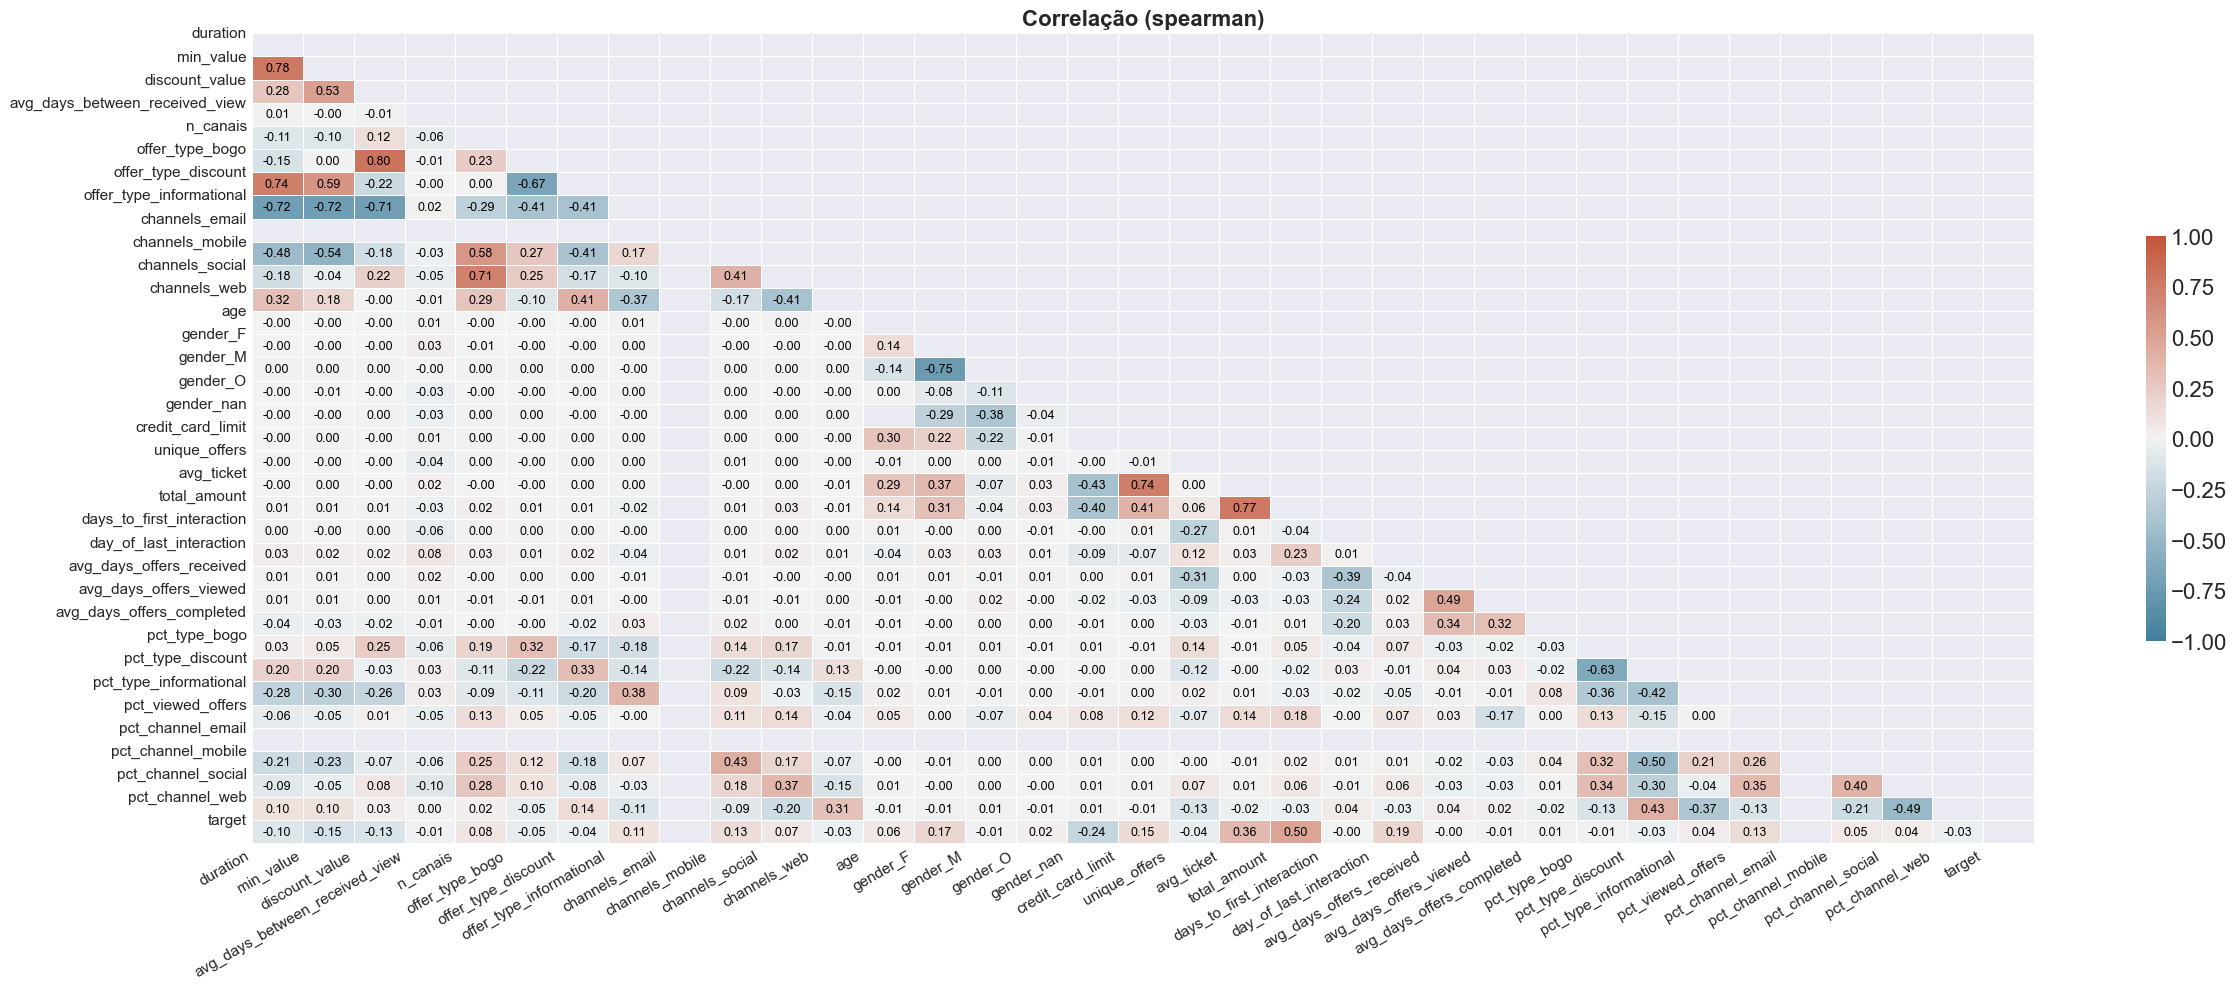

In [279]:
from src.plots import plot_corr
plot_corr(data_model[FEATURES + [TARGET]], method="spearman")

Já é possível observar que algumas features -- como `channels_email` e `pdt_channel_email` -- serão eliminadas por falta de importância

### **FEATURE SELECTION**

2025-05-12 01:05:18.711 | INFO     | src.utils:feature_selection:266 - Train AUC: 0.8772
2025-05-12 01:05:18.711 | INFO     | src.utils:feature_selection:267 - Valid AUC: 0.8390
2025-05-12 01:05:28.017 | SUCCESS  | src.utils:feature_selection:292 - POSITIVE IMPORTANCE:
2025-05-12 01:05:28.017 | SUCCESS  | src.utils:feature_selection:294 - 0.157304: total_amount
2025-05-12 01:05:28.017 | SUCCESS  | src.utils:feature_selection:294 - 0.039272: avg_days_offers_completed
2025-05-12 01:05:28.017 | SUCCESS  | src.utils:feature_selection:294 - 0.035929: duration
2025-05-12 01:05:28.017 | SUCCESS  | src.utils:feature_selection:294 - 0.024826: avg_ticket
2025-05-12 01:05:28.018 | SUCCESS  | src.utils:feature_selection:294 - 0.015037: min_value
2025-05-12 01:05:28.018 | SUCCESS  | src.utils:feature_selection:294 - 0.007153: discount_value
2025-05-12 01:05:28.018 | SUCCESS  | src.utils:feature_selection:294 - 0.006636: day_of_last_interaction
2025-05-12 01:05:28.018 | SUCCESS  | src.utils:feature_

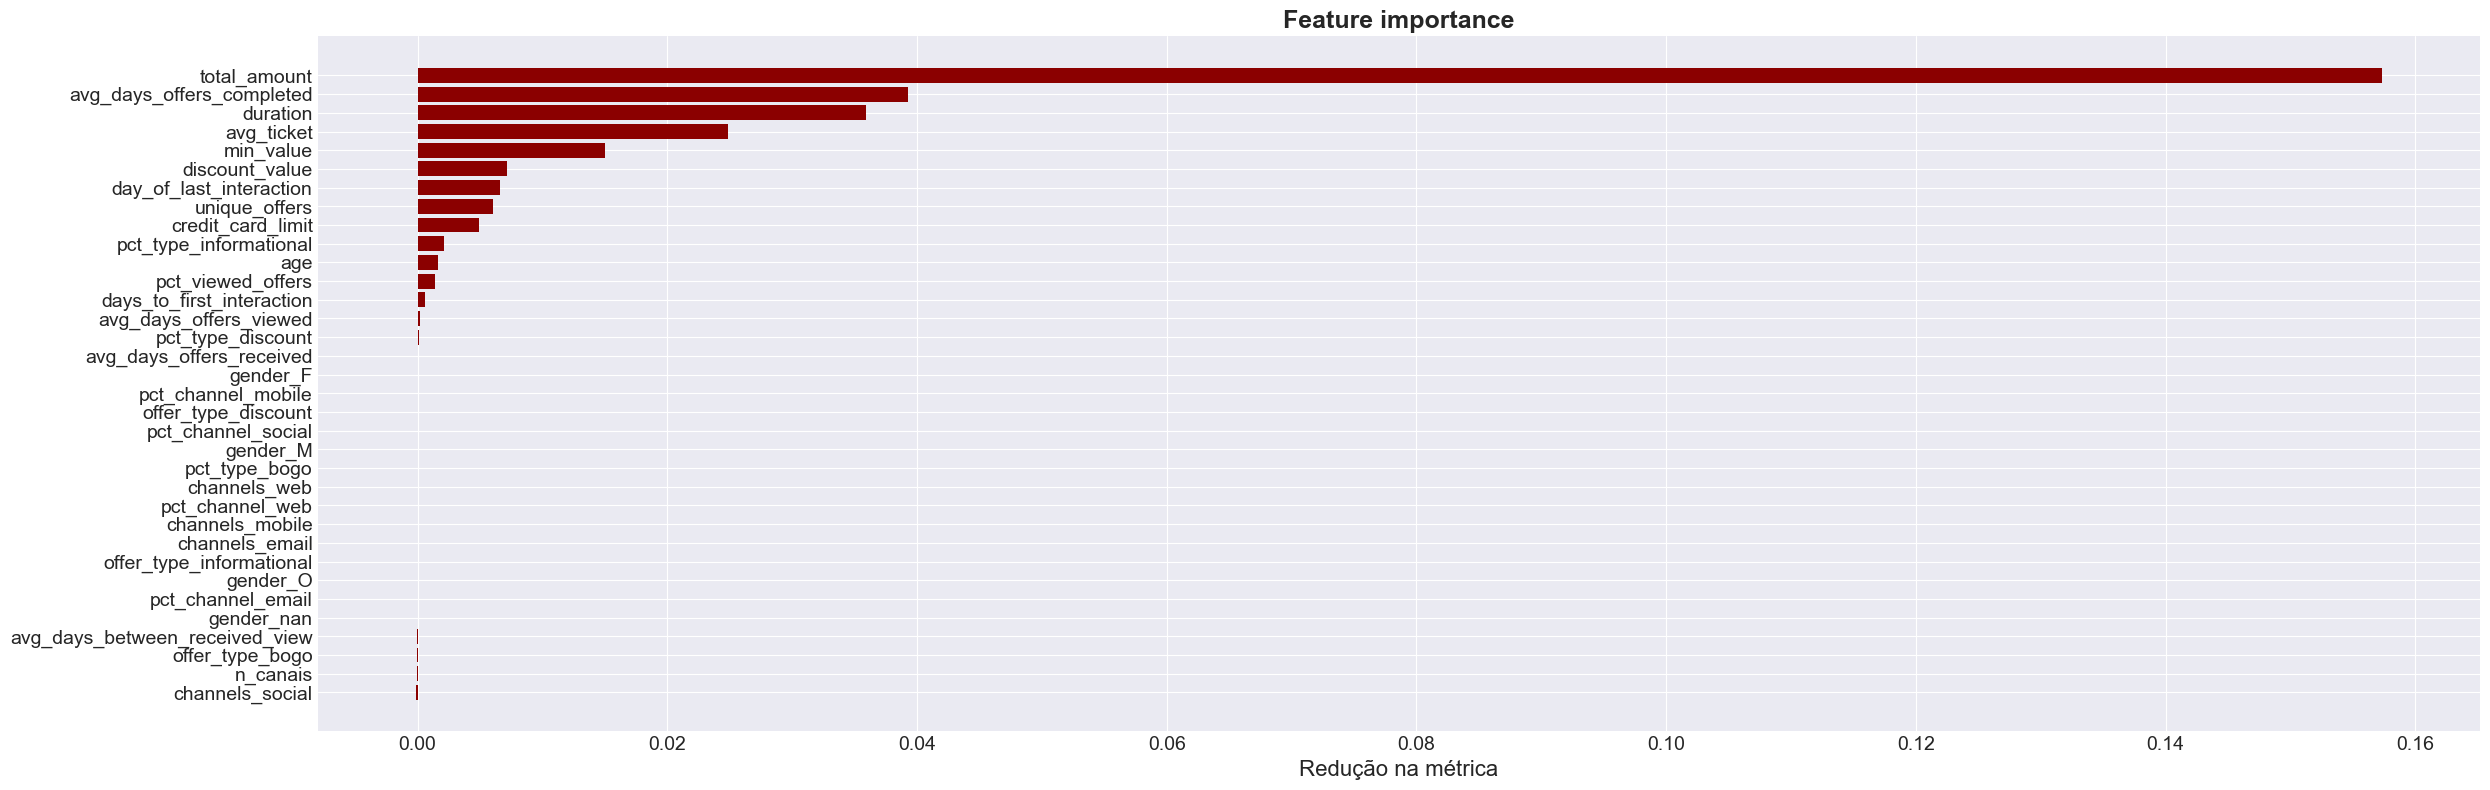

In [280]:
from src.utils import feature_selection
SELECTED_FEATURES = feature_selection(
    data=dtrain, features=FEATURES, target=TARGET
)

In [281]:
SELECTED_FEATURES

['total_amount',
 'avg_days_offers_completed',
 'duration',
 'avg_ticket',
 'min_value',
 'discount_value',
 'day_of_last_interaction',
 'unique_offers',
 'credit_card_limit',
 'pct_type_informational',
 'age',
 'pct_viewed_offers',
 'days_to_first_interaction',
 'avg_days_offers_viewed',
 'pct_type_discount',
 'avg_days_offers_received',
 'gender_F',
 'pct_channel_mobile',
 'offer_type_discount',
 'pct_channel_social',
 'gender_M',
 'pct_type_bogo',
 'channels_web',
 'pct_channel_web']

In [339]:
SELECTED_FEATURES = [
    # 'total_amount',
    # 'avg_days_offers_completed',
    'duration',
    'avg_ticket',
    'min_value',
    'discount_value',
    'day_of_last_interaction',
    'unique_offers',
    'credit_card_limit',
    # 'pct_type_informational',
    'age',
    'pct_viewed_offers',
    'days_to_first_interaction',
    'avg_days_offers_viewed',
    'pct_type_discount',
    'avg_days_offers_received',
    # 'gender_F',
    # 'pct_channel_mobile',
    'offer_type_discount',
    # 'pct_channel_social',
    # 'gender_M',
    # 'pct_type_bogo',
    # 'channels_web',
    # 'pct_channel_web'
]

### **MODEL**

#### **Optimization**

In [344]:
from src.hyperopt import RollingWindowOptimizer
optmizer = RollingWindowOptimizer(
    data=dtrain,
    features=SELECTED_FEATURES,
    target=TARGET,
    n_folds=5,
    trials=10
)
optmizer.run()

2025-05-12 01:24:09.446 | INFO     | src.hyperopt:run:24 -  Optimizing...
2025-05-12 01:24:09.759 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 1: Logloss=0.51839 (σ=0.00081) | AUC=0.78899 (σ=0.00005) | Brier=0.16996 (σ=0.00019)
2025-05-12 01:24:10.099 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 2: Logloss=0.51495 (σ=0.00082) | AUC=0.78303 (σ=0.00006) | Brier=0.17188 (σ=0.00019)
2025-05-12 01:24:10.759 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 3: Logloss=0.50688 (σ=0.00067) | AUC=0.80051 (σ=0.00007) | Brier=0.16670 (σ=0.00018)
2025-05-12 01:24:11.335 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 4: Logloss=0.51556 (σ=0.00091) | AUC=0.78630 (σ=0.00007) | Brier=0.17054 (σ=0.00019)
2025-05-12 01:24:12.001 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 5: Logloss=0.50917 (σ=0.00063) | AUC=0.79759 (σ=0.00008) | Brier=0.16741 (σ=0.00019)
2025-05-12 01:24:12.666 | SUCCESS  | src.hyperopt:train:66 -  TRIAL 6: Logloss=0.50816 (σ=0.00076) | AUC=0.79927 (σ=0.00009) | Brier=0.16709 (σ=0.00018)
2025-05-

In [345]:
best_params = optmizer.best_params
best_params

{'max_depth': 4,
 'num_leaves': 5,
 'n_estimators': 130,
 'learning_rate': 0.1,
 'pos_bagging_fraction': 0.7755114312327025,
 'neg_bagging_fraction': 0.8884059081337375,
 'bagging_freq': 7}

#### **Traning**

In [346]:
from src.model import train_model

lgbm_calib, X_train, y_train, y_test, preds = train_model(
    dtrain=dtrain,
    dtest=dtest,
    features=SELECTED_FEATURES,
    target=TARGET, 
    params=best_params
)

2025-05-12 01:24:18.242 | INFO     | src.model:train_model:83 - Running model training...
2025-05-12 01:24:18.964 | INFO     | src.model:train_model:86 - Validation Performance: AUC: 0.8004 | Brier: 0.1669
2025-05-12 01:24:19.153 | SUCCESS  | src.model:train_model:102 - Test Model Performance: AUC 0.8047 | Brier: 0.1674


2025-05-12 01:24:20.669 | INFO     | src.utils:get_roc_auc_curve:342 -  Resulting metrics based on the optimal threshold:
2025-05-12 01:24:20.669 | INFO     | src.utils:get_roc_auc_curve:343 - Threshold=0.3771


2025-05-12 01:24:20.669 | INFO     | src.utils:get_roc_auc_curve:344 - AUC=0.7296


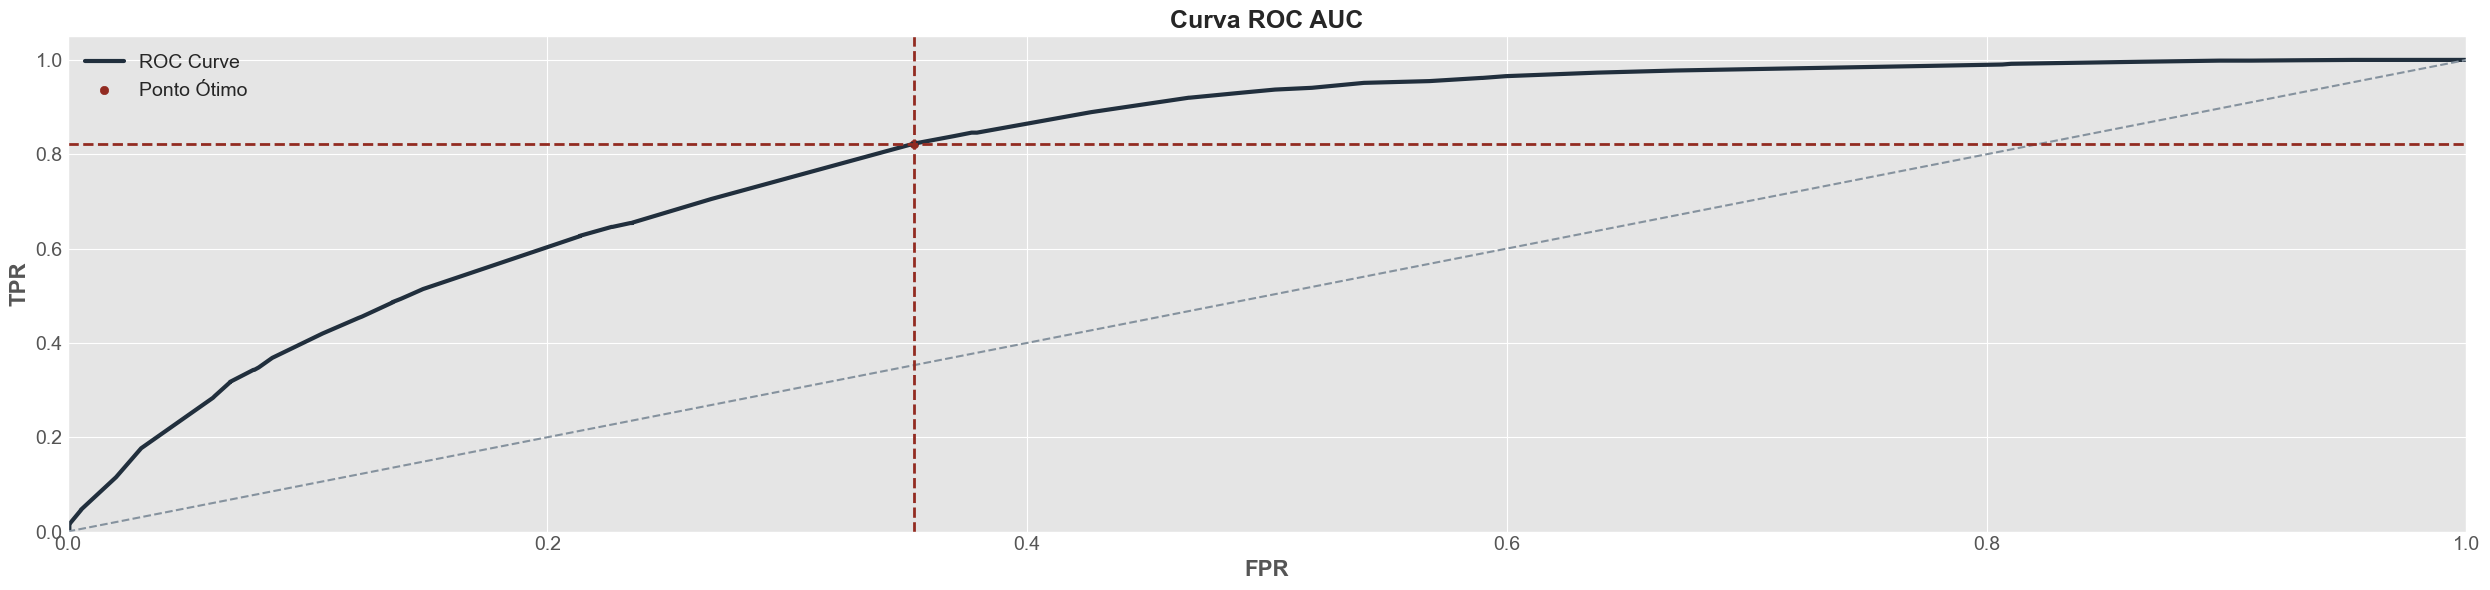

In [347]:
from src.utils import get_roc_auc_curve
optimal_threshold = get_roc_auc_curve(y=y_test, y_pred=preds)

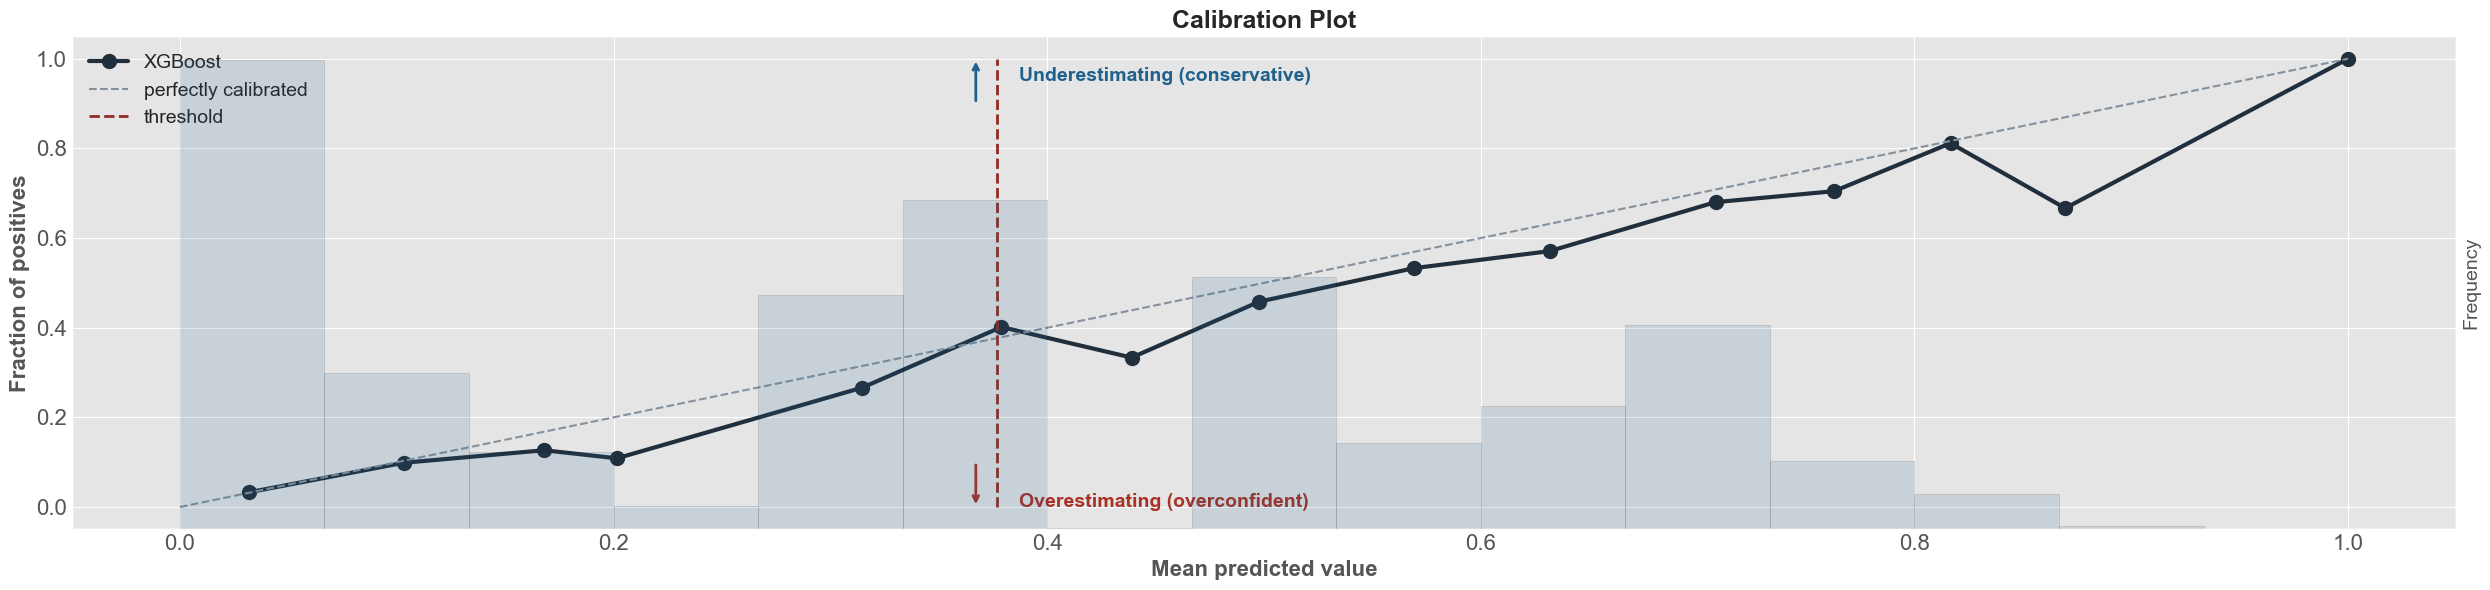

In [348]:
from src.plots import plot_calibration_curve
plot_calibration_curve(y=y_test, preds=preds, threshold=optimal_threshold)

#### **SHAP**

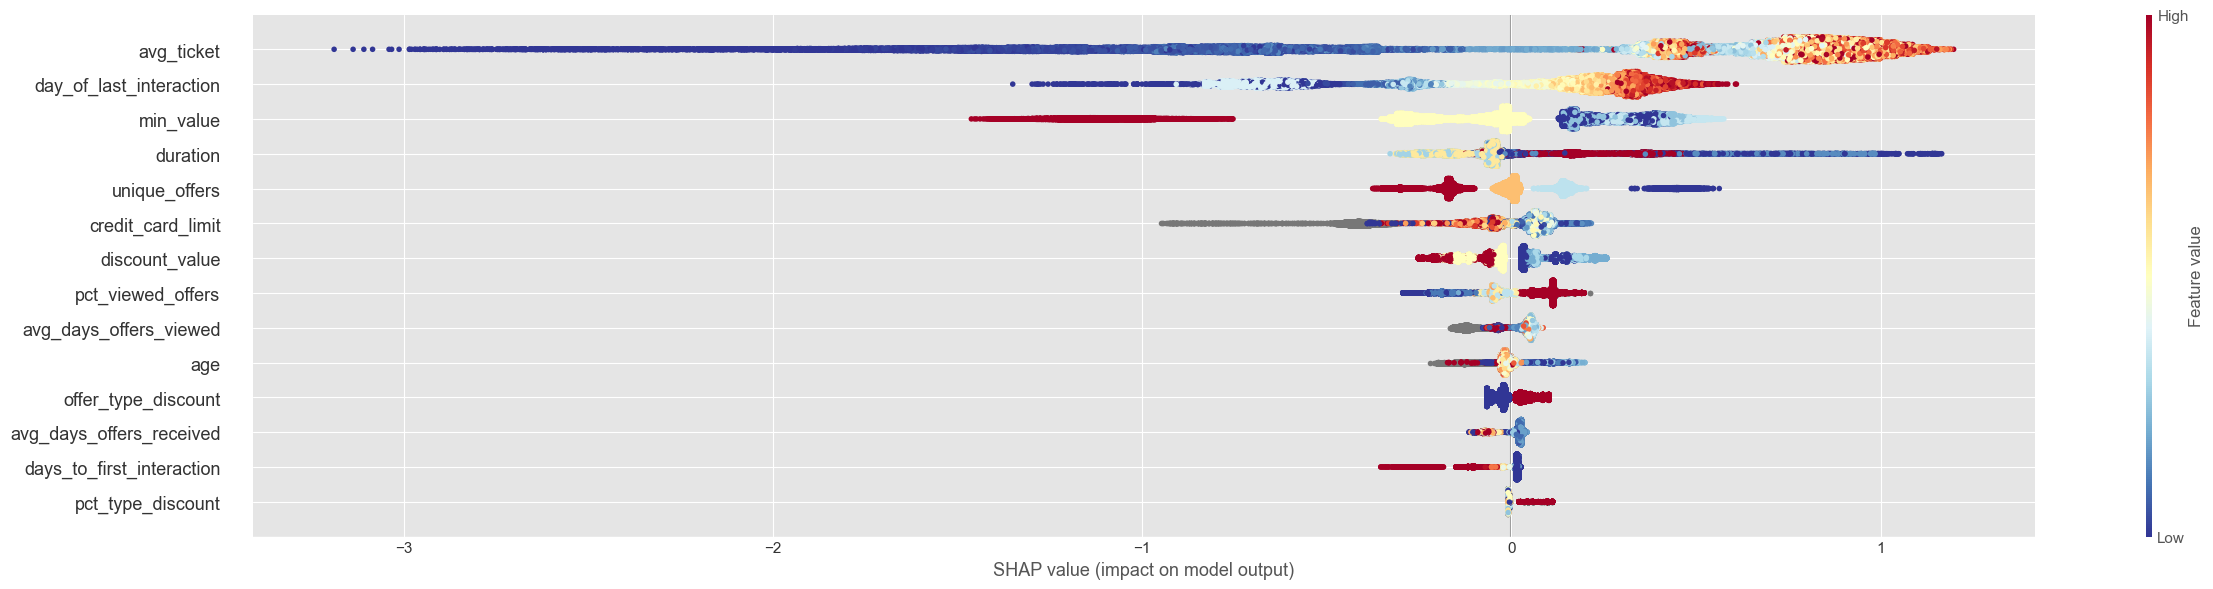

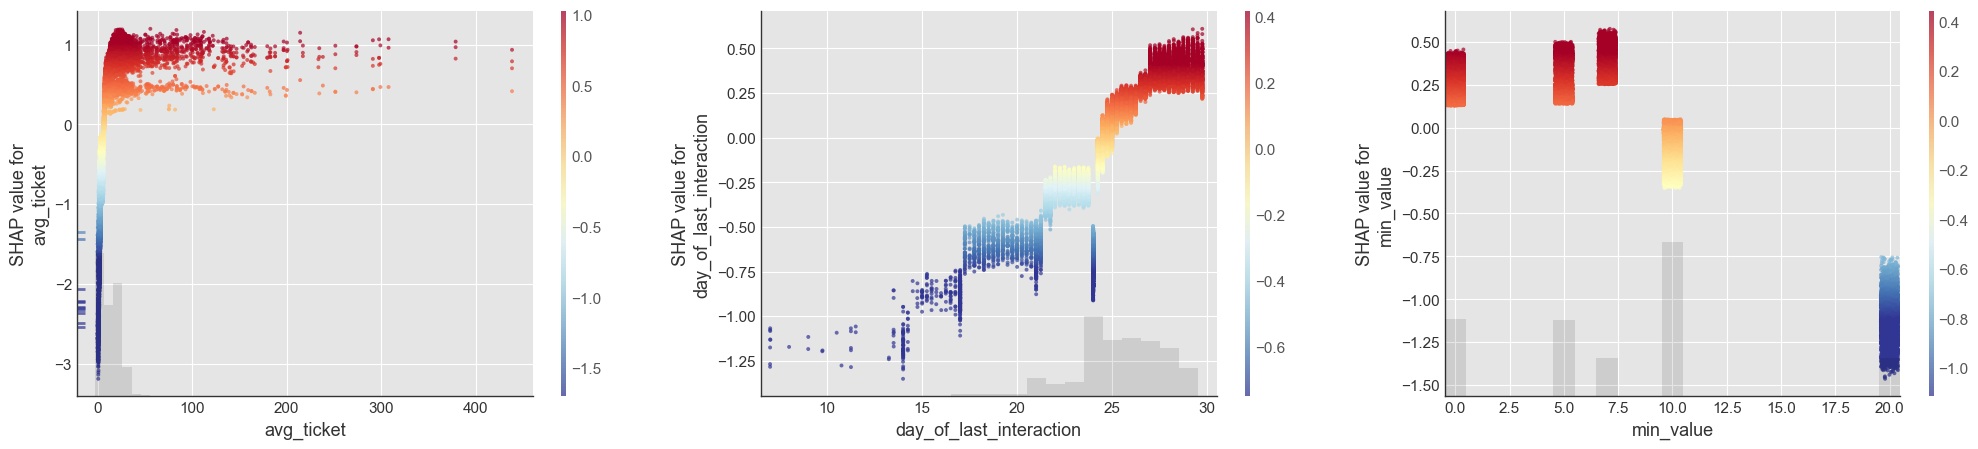

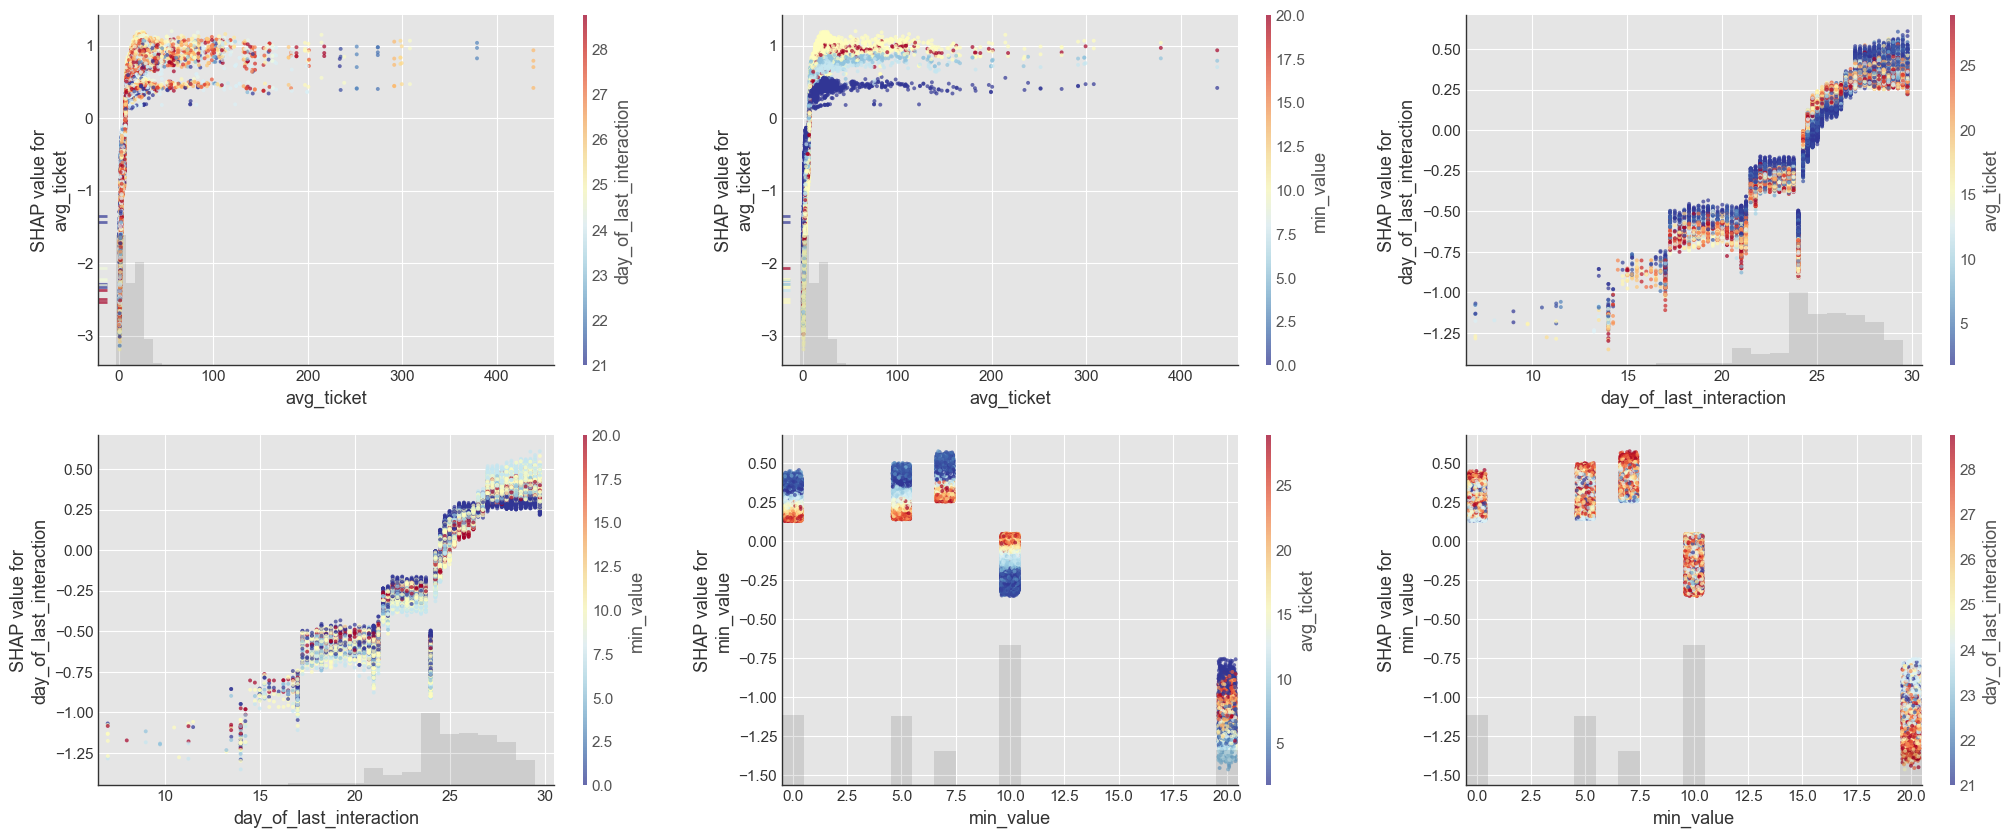

In [349]:
from src.plots import visualize_feature_importance
visualize_feature_importance(model=lgbm_calib, X=X_train, scatter_n_top_feats=3)

In [ ]:
 # # Plota curva de calibração (apenas para o último fold)
    # if fold == n_splits - 1:
    #     prob_true, prob_pred = calibration_curve(y_valid, preds, n_bins=10)
    #     plt.figure(figsize=(6, 6))
    #     plt.plot(prob_pred, prob_true, marker='o', label='Modelo Calibrado')
    #     plt.plot([0, 1], [0, 1], '--', label='Ideal')
    #     plt.xlabel('Probabilidade prevista')
    #     plt.ylabel('Frequência observada')
    #     plt.title('Curva de calibração - Último Fold')
    #     plt.legend()
    #     plt.grid()
    #     plt.show()